
Random Forest - Processing Dataset: diabetes.csv (Target: Outcome)

Dataset: diabetes.csv | Classifier: Random Forest

Regression Coefficients:
Entropy  Coefficient (β)
    H_D        24.639998
 H_pred         0.274711
 H_conf        -0.049392

Intercept (β₀): -22.33334
Model R² score: 0.55112
MSE: 0.00065
RMSE: 0.02557

Observed vs Predicted Precision:
 Index  Observed  Predicted  Difference
     0  0.693657   0.667526    0.026132
     1  0.669808   0.647237    0.022570
     2  0.671092   0.656232    0.014860
     3  0.657576   0.643255    0.014321
     4  0.579955   0.650393   -0.070438
     5  0.669481   0.743215   -0.073734
     6  0.756352   0.718580    0.037772
     7  0.728112   0.721096    0.007016
     8  0.681071   0.706143   -0.025072
     9  0.700350   0.716747   -0.016398
    10  0.762744   0.752654    0.010090
    11  0.736735   0.726686    0.010049
    12  0.718939   0.726672   -0.007733
    13  0.750000   0.715174    0.034826
    14  0.700666   0.729992   -0.029326
   

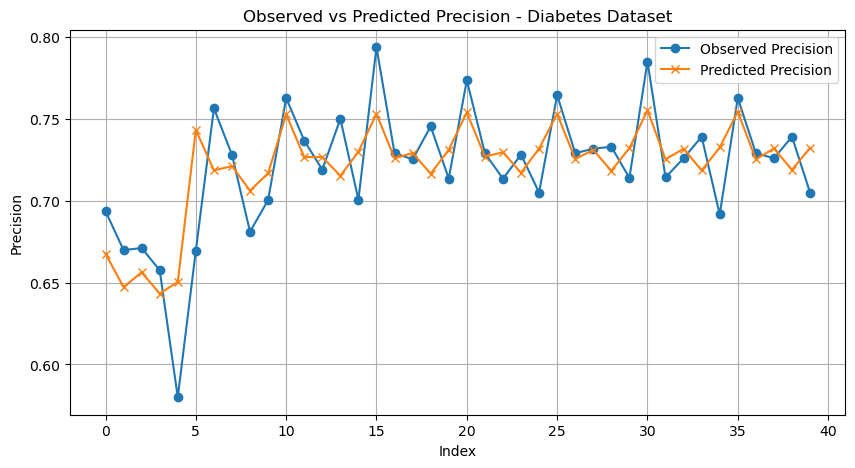

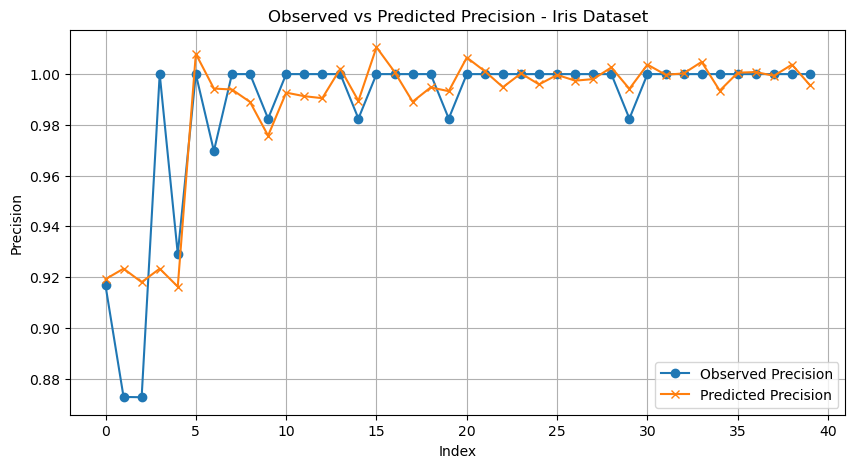

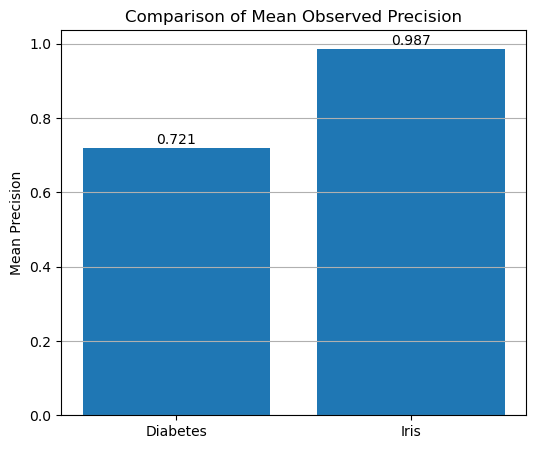

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, mean_squared_error
from scipy.stats import entropy
from sklearn.linear_model import LinearRegression

# Function to compute active components for Precision: H_D, H_pred, H_conf
def compute_entropies_and_precision(n_estimators, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, max_depth=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    probs = rf.predict_proba(X_test)

    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)

    # H_D: class distribution entropy from training set
    class_probs = np.bincount(y_train) / len(y_train)
    H_D = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_conf: entropy of prediction confidence (max probability per sample)
    confidences = np.max(probs, axis=1)
    confidence_bins = np.histogram(confidences, bins=10, range=(0, 1))[0]
    confidence_probs = confidence_bins / np.sum(confidence_bins)
    confidence_probs = confidence_probs[confidence_probs > 0]
    H_conf = entropy(confidence_probs, base=2) if len(confidence_probs) > 0 else 0.0

    return H_D, H_pred, H_conf, prec

# Dataset configurations
datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("Iris.csv", "Species")
]

# Process each dataset with Random Forest
for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"Random Forest - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        # Load dataset
        data = pd.read_csv(csv_file)
        
        # Drop non-numeric and irrelevant columns
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        
        # Drop rows with missing values
        data = data.dropna()
        
        # Encode categorical columns
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        # Run multiple configurations with different n_estimators values
        records = []
        for n_est in [1, 10, 50, 100, 150, 200, 250, 300]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_D, H_pred, H_conf, prec = compute_entropies_and_precision(n_est, test_size=split)
                records.append({
                    "n_estimators": n_est,
                    "split": split,
                    "H_D": H_D,
                    "H_pred": H_pred,
                    "H_conf": H_conf,
                    "Precision": prec
                })
        
        df = pd.DataFrame(records)
        
        # Linear regression: Precision as function of entropies
        X_reg = df[["H_D", "H_pred", "H_conf"]].values
        y_reg = df["Precision"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        # Coefficients
        coeffs = pd.DataFrame({
            "Entropy": ["H_D", "H_pred", "H_conf"],
            "Coefficient (β)": model.coef_
        })
        
        # Compute MSE and RMSE
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: Random Forest")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted Precision:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table (with n_estimators and split variations):")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        # Summary statistics
        print(f"\nSummary Statistics:")
        print(f"Mean Observed Precision: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted Precision: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# ================================
# Diabetes Observed & Predicted
# ================================
obs_diabetes = [
0.693657,0.669808,0.671092,0.657576,0.579955,0.669481,0.756352,0.728112,
0.681071,0.700350,0.762744,0.736735,0.718939,0.750000,0.700666,0.793750,
0.729038,0.725245,0.745371,0.713545,0.773611,0.729038,0.713450,0.728175,
0.704993,0.764550,0.729038,0.731729,0.732972,0.713889,0.785009,0.714231,
0.725926,0.739087,0.691621,0.762744,0.729038,0.725926,0.739087,0.704993
]

pred_diabetes = [
0.667526,0.647237,0.656232,0.643255,0.650393,0.743215,0.718580,0.721096,
0.706143,0.716747,0.752654,0.726686,0.726672,0.715174,0.729992,0.753066,
0.725889,0.729159,0.716513,0.731096,0.753920,0.726959,0.729584,0.717069,
0.731857,0.753005,0.725502,0.730985,0.718262,0.732121,0.755267,0.725306,
0.731739,0.718526,0.732527,0.754323,0.725225,0.731947,0.718875,0.732270
]


# ================================
# Iris Observed & Predicted
# ================================
obs_iris = [
0.916667,0.872727,0.872627,1.0,0.929167,1.0,0.969697,1.0,1.0,0.982456,
1.0,1.0,1.0,1.0,0.982456,1.0,1.0,1.0,1.0,0.982456,1.0,1.0,1.0,1.0,
1.0,1.0,1.0,1.0,1.0,0.982456,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
]

pred_iris = [
0.919168,0.923303,0.917987,0.923303,0.916219,1.007990,0.994296,0.993920,
0.989015,0.975724,0.992692,0.991295,0.990502,1.002134,0.989444,1.010593,
1.000865,0.989120,0.994752,0.993273,1.006522,1.001115,0.994849,1.000247,
0.995939,0.999679,0.997412,0.998033,1.002628,0.994193,1.003743,0.999751,
1.000255,1.004822,0.993468,1.000553,1.000803,0.999326,1.003746,0.995578
]


# ================================
# Compute Mean Values
# ================================
mean_obs_diabetes = sum(obs_diabetes) / len(obs_diabetes)
mean_obs_iris = sum(obs_iris) / len(obs_iris)


# ====================================================
# 1️⃣ Plot: Observed vs Predicted — Diabetes Dataset
# ====================================================
plt.figure(figsize=(10,5))
plt.plot(obs_diabetes, label="Observed Precision", marker='o')
plt.plot(pred_diabetes, label="Predicted Precision", marker='x')
plt.title("Observed vs Predicted Precision - Diabetes Dataset")
plt.xlabel("Index")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()


# ====================================================
# 2️⃣ Plot: Observed vs Predicted — Iris Dataset
# ====================================================
plt.figure(figsize=(10,5))
plt.plot(obs_iris, label="Observed Precision", marker='o')
plt.plot(pred_iris, label="Predicted Precision", marker='x')
plt.title("Observed vs Predicted Precision - Iris Dataset")
plt.xlabel("Index")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()


# ====================================================
# 3️⃣ Bar Plot: Comparison of Mean Observed Precision
# ====================================================
plt.figure(figsize=(6,5))

# Bar plot
plt.bar(["Diabetes", "Iris"], [mean_obs_diabetes, mean_obs_iris])

# Display values above bars
plt.text(0, mean_obs_diabetes + 0.01, f"{mean_obs_diabetes:.3f}", ha='center')
plt.text(1, mean_obs_iris + 0.01, f"{mean_obs_iris:.3f}", ha='center')

plt.title("Comparison of Mean Observed Precision")
plt.ylabel("Mean Precision")
plt.grid(axis='y')

plt.show()


SVM - Processing Dataset: diabetes.csv (Target: Outcome)

Dataset: diabetes.csv | Classifier: SVM

Regression Coefficients:
Entropy  Coefficient (β)
    H_D        18.940695
 H_pred         0.675281
 H_conf        -0.818833

Intercept (β₀): -15.76476
Model R² score: 0.30023
MSE: 0.01887
RMSE: 0.13738

Observed vs Predicted Precision:
 Index  Observed  Predicted  Difference
     0  0.327586   0.510460   -0.182874
     1  0.324675   0.490751   -0.166076
     2  0.325521   0.501777   -0.176256
     3  0.324675   0.502735   -0.178060
     4  0.325279   0.547465   -0.222186
     5  0.327586   0.512147   -0.184560
     6  0.324675   0.494635   -0.169960
     7  0.325521   0.505877   -0.180356
     8  0.324675   0.500987   -0.176312
     9  0.325279   0.540007   -0.214728
    10  0.748718   0.515669    0.233049
    11  0.690196   0.509078    0.181118
    12  0.702354   0.504799    0.197555
    13  0.742759   0.499325    0.243434
    14  0.730281   0.541785    0.188496
    15  0.771930   0.65

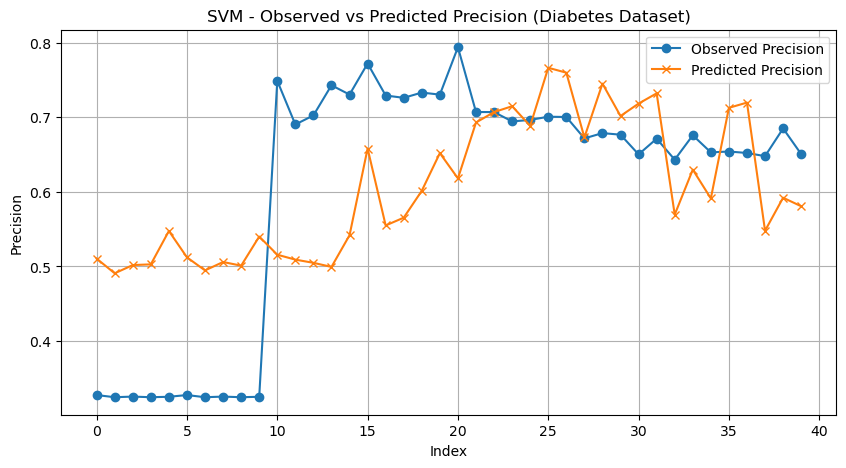

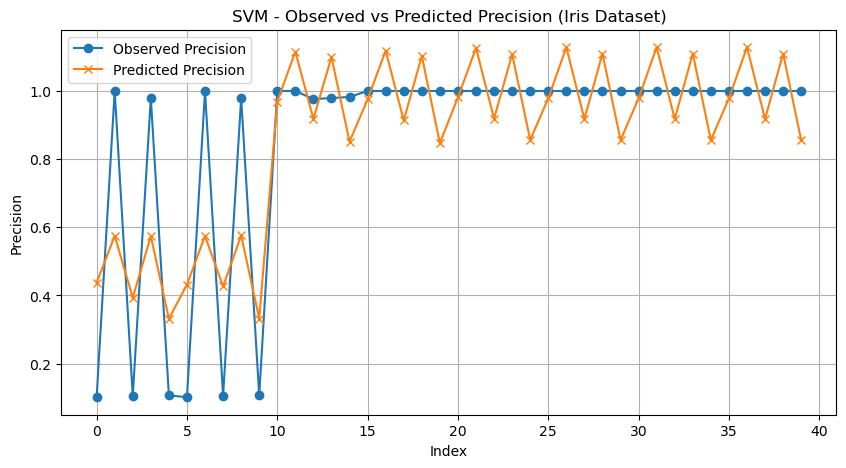

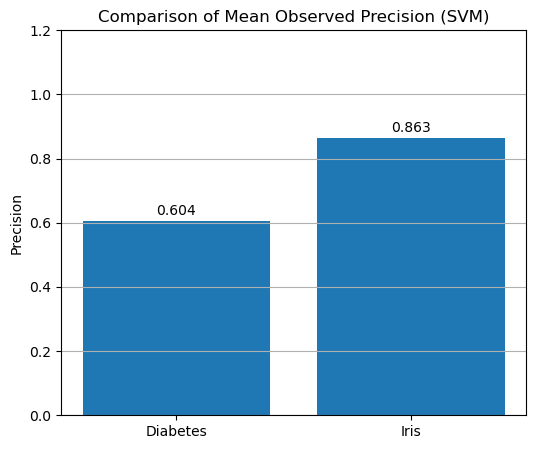

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import precision_score, mean_squared_error
from scipy.stats import entropy
from sklearn.linear_model import LinearRegression

# Function to compute entropies for SVM with Precision
def compute_entropies_and_precision(C, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    svm = SVC(C=C, kernel='rbf', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    probs = svm.predict_proba(X_test)

    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)

    # H_D: class distribution entropy from training set
    class_probs = np.bincount(y_train) / len(y_train)
    H_D = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_conf: entropy of prediction confidence (max probability per sample)
    confidences = np.max(probs, axis=1)
    confidence_bins = np.histogram(confidences, bins=10, range=(0, 1))[0]
    confidence_probs = confidence_bins / np.sum(confidence_bins)
    confidence_probs = confidence_probs[confidence_probs > 0]
    H_conf = entropy(confidence_probs, base=2) if len(confidence_probs) > 0 else 0.0

    return H_D, H_pred, H_conf, prec

# Dataset configurations
datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("Iris.csv", "Species")
]

# Process each dataset with SVM
for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"SVM - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        # Load dataset
        data = pd.read_csv(csv_file)
        
        # Drop non-numeric and irrelevant columns
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        
        # Drop rows with missing values
        data = data.dropna()
        
        # Encode categorical columns
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        # Run multiple configurations with different C values
        records = []
        for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_D, H_pred, H_conf, prec = compute_entropies_and_precision(C, test_size=split)
                records.append({
                    "C": C,
                    "split": split,
                    "H_D": H_D,
                    "H_pred": H_pred,
                    "H_conf": H_conf,
                    "Precision": prec
                })
        
        df = pd.DataFrame(records)
        
        # Linear regression: Precision as function of entropies
        X_reg = df[["H_D", "H_pred", "H_conf"]].values
        y_reg = df["Precision"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        # Coefficients
        coeffs = pd.DataFrame({
            "Entropy": ["H_D", "H_pred", "H_conf"],
            "Coefficient (β)": model.coef_
        })
        
        # Compute MSE and RMSE
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: SVM")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted Precision:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table (with C and split variations):")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        # Summary statistics
        print(f"\nSummary Statistics:")
        print(f"Mean Observed Precision: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted Precision: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# ============================
# Extract Observed & Predicted
# ============================

# Diabetes
observed_diabetes = [
0.327586,0.324675,0.325521,0.324675,0.325279,0.327586,0.324675,0.325521,
0.324675,0.325279,0.748718,0.690196,0.702354,0.742759,0.730281,0.771930,
0.729038,0.725926,0.732972,0.730221,0.793750,0.706929,0.706818,0.694310,
0.696302,0.700621,0.700244,0.671578,0.678646,0.676529,0.650123,0.671162,
0.643056,0.675699,0.652841,0.653991,0.651999,0.647771,0.684878,0.650525
]

predicted_diabetes = [
0.510460,0.490751,0.501777,0.502735,0.547465,0.512147,0.494635,0.505877,
0.500987,0.540007,0.515669,0.509078,0.504799,0.499325,0.541785,0.657964,
0.554873,0.565321,0.601401,0.651845,0.617951,0.692870,0.706828,0.714678,
0.688349,0.766195,0.759614,0.672800,0.744963,0.701560,0.718219,0.731958,
0.569369,0.629682,0.591138,0.712536,0.719541,0.547805,0.592053,0.580633
]

# Iris
observed_iris = [
0.101449,1.000000,0.105263,0.979167,0.106918,0.101449,1.000000,0.105263,
0.979167,0.106918,1.000000,1.000000,0.976190,0.979167,0.982456,1.000000,
1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,
1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,
1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
]

predicted_iris = [
0.437229,0.575065,0.393486,0.574214,0.331411,0.431950,0.574358,0.426568,
0.576036,0.332403,0.969015,1.115219,0.917951,1.099678,0.851219,0.975434,
1.118261,0.913563,1.102694,0.847244,0.981119,1.126103,0.918578,1.108050,
0.856620,0.978166,1.128344,0.917698,1.109888,0.855885,0.978166,1.128344,
0.917698,1.109888,0.855885,0.978166,1.128344,0.917698,1.109888,0.855885
]

# ============================
# Mean Precision Values
# ============================

mean_diabetes = sum(observed_diabetes) / len(observed_diabetes)
mean_iris = sum(observed_iris) / len(observed_iris)


# ==========================================
# 1️⃣ Line Graph: Observed vs Predicted (Diabetes)
# ==========================================

plt.figure(figsize=(10,5))
plt.plot(observed_diabetes, label="Observed Precision", marker='o')
plt.plot(predicted_diabetes, label="Predicted Precision", marker='x')
plt.title("SVM - Observed vs Predicted Precision (Diabetes Dataset)")
plt.xlabel("Index")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()


# ==========================================
# 2️⃣ Line Graph: Observed vs Predicted (Iris)
# ==========================================

plt.figure(figsize=(10,5))
plt.plot(observed_iris, label="Observed Precision", marker='o')
plt.plot(predicted_iris, label="Predicted Precision", marker='x')
plt.title("SVM - Observed vs Predicted Precision (Iris Dataset)")
plt.xlabel("Index")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()


# ==========================================
# 3️⃣ Bar Chart: Mean Observed Precision Comparison
# ==========================================

plt.figure(figsize=(6,5))
plt.bar(["Diabetes", "Iris"], [mean_diabetes, mean_iris])

plt.text(0, mean_diabetes + 0.02, f"{mean_diabetes:.3f}", ha='center')
plt.text(1, mean_iris + 0.02, f"{mean_iris:.3f}", ha='center')

plt.title("Comparison of Mean Observed Precision (SVM)")
plt.ylabel("Precision")
plt.ylim(0, 1.2)
plt.grid(axis='y')
plt.show()



KNN - Processing Dataset: diabetes.csv (Target: Outcome)

Dataset: diabetes.csv | Classifier: KNN

Regression Coefficients:
Entropy  Coefficient (β)
    H_D         8.445241
 H_pred        -0.204800
 H_conf         0.086042

Intercept (β₀): -7.20926
Model R² score: 0.60733
MSE: 0.00041
RMSE: 0.02030

Observed vs Predicted Precision:
 Index  Observed  Predicted  Difference
     0  0.656579   0.676858   -0.020279
     1  0.677613   0.668061    0.009552
     2  0.671092   0.671288   -0.000196
     3  0.704545   0.665747    0.038799
     4  0.675468   0.669304    0.006165
     5  0.686016   0.670469    0.015548
     6  0.662955   0.663638   -0.000684
     7  0.657617   0.672417   -0.014800
     8  0.668132   0.665790    0.002343
     9  0.646902   0.673068   -0.026166
    10  0.683373   0.700314   -0.016941
    11  0.669025   0.694339   -0.025314
    12  0.676023   0.702180   -0.026157
    13  0.684198   0.693688   -0.009490
    14  0.692620   0.697835   -0.005216
    15  0.744092   0.723

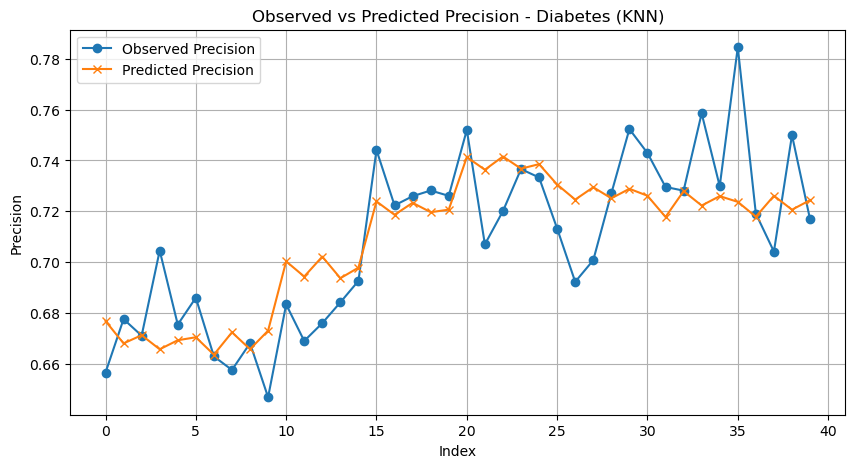

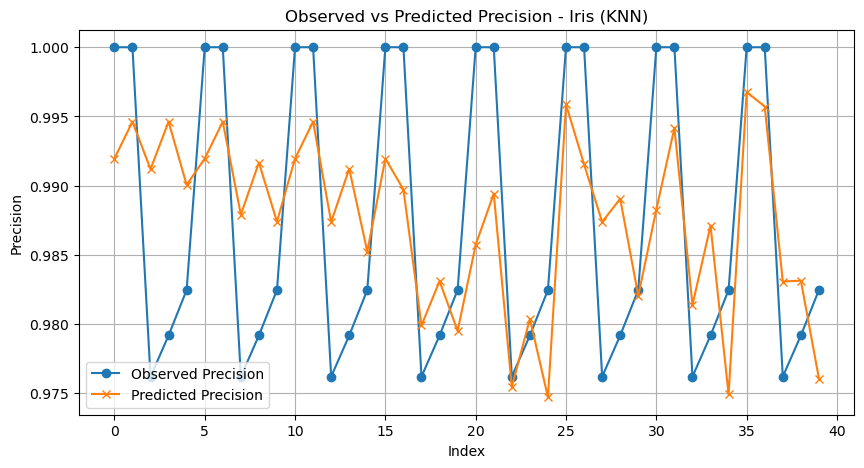

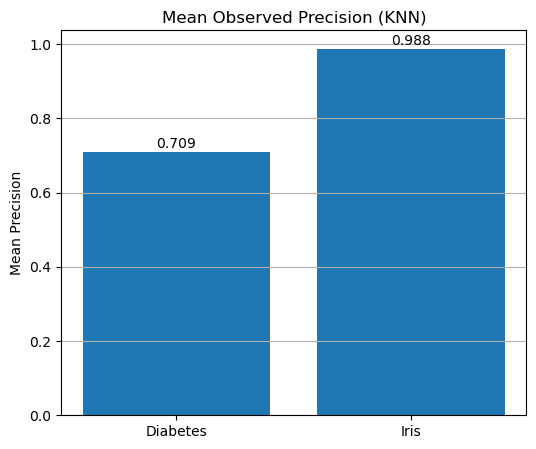

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_score, mean_squared_error
from scipy.stats import entropy

# Function to compute entropies for KNN with Precision
def compute_entropies_and_precision(n_neighbors, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    probs = knn.predict_proba(X_test)

    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)

    # H_D: class distribution entropy from training set
    class_probs = np.bincount(y_train) / len(y_train)
    H_D = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_conf: entropy of prediction confidence (max probability per sample)
    confidences = np.max(probs, axis=1)
    confidence_bins = np.histogram(confidences, bins=10, range=(0, 1))[0]
    confidence_probs = confidence_bins / np.sum(confidence_bins)
    confidence_probs = confidence_probs[confidence_probs > 0]
    H_conf = entropy(confidence_probs, base=2) if len(confidence_probs) > 0 else 0.0

    return H_D, H_pred, H_conf, prec

# Dataset configurations
datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("Iris.csv", "Species")
]

# Process each dataset with KNN
for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"KNN - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        # Load dataset
        data = pd.read_csv(csv_file)
        
        # Drop non-numeric and irrelevant columns
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        
        # Drop rows with missing values
        data = data.dropna()
        
        # Encode categorical columns
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        # Run multiple configurations with different k (n_neighbors) values
        records = []
        for k in [1, 3, 5, 7, 9, 11, 15, 21]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_D, H_pred, H_conf, prec = compute_entropies_and_precision(k, test_size=split)
                records.append({
                    "k": k,
                    "split": split,
                    "H_D": H_D,
                    "H_pred": H_pred,
                    "H_conf": H_conf,
                    "Precision": prec
                })
        
        df = pd.DataFrame(records)
        
        # Linear regression: Precision as function of entropies
        X_reg = df[["H_D", "H_pred", "H_conf"]].values
        y_reg = df["Precision"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        # Coefficients
        coeffs = pd.DataFrame({
            "Entropy": ["H_D", "H_pred", "H_conf"],
            "Coefficient (β)": model.coef_
        })
        
        # Compute MSE and RMSE
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: KNN")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted Precision:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table (with k and split variations):")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        # Summary statistics
        print(f"\nSummary Statistics:")
        print(f"Mean Observed Precision: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted Precision: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# =====================================================================
# Diabetes Observed & Predicted (from your KNN output)
# =====================================================================

obs_diabetes = [
0.656579,0.677613,0.671092,0.704545,0.675468,0.686016,0.662955,0.657617,
0.668132,0.646902,0.683373,0.669025,0.676023,0.684198,0.692620,0.744092,
0.722311,0.725926,0.728175,0.726065,0.751974,0.706999,0.720063,0.736576,
0.733297,0.713225,0.692271,0.700777,0.727016,0.752319,0.742901,0.729560,
0.728112,0.758480,0.729863,0.784496,0.719079,0.704153,0.749947,0.716866
]

pred_diabetes = [
0.676858,0.668061,0.671288,0.665747,0.669304,0.670469,0.663638,0.672417,
0.665790,0.673068,0.700314,0.694339,0.702180,0.693688,0.697835,0.723875,
0.718622,0.723327,0.719646,0.720633,0.741305,0.736336,0.741533,0.736755,
0.738523,0.730515,0.724598,0.729449,0.725103,0.728837,0.726110,0.717754,
0.727915,0.722259,0.725954,0.723704,0.717860,0.726095,0.720621,0.724379
]

# =====================================================================
# Iris Observed & Predicted (from your KNN output)
# =====================================================================

obs_iris = [
1.000000,1.000000,0.976190,0.979167,0.982456,1.000000,1.000000,0.976190,
0.979167,0.982456,1.000000,1.000000,0.976190,0.979167,0.982456,1.000000,
1.000000,0.976190,0.979167,0.982456,1.000000,1.000000,0.976190,0.979167,
0.982456,1.000000,1.000000,0.976190,0.979167,0.982456,1.000000,1.000000,
0.976190,0.979167,0.982456,1.000000,1.000000,0.976190,0.979167,0.982456
]

pred_iris = [
0.991950,0.994616,0.991189,0.994616,0.990049,0.991950,0.994616,0.987902,
0.991660,0.987392,0.991950,0.994616,0.987373,0.991213,0.985231,0.991950,
0.989716,0.979893,0.983095,0.979496,0.985723,0.989415,0.975436,0.980366,
0.974703,0.995862,0.991531,0.987372,0.989047,0.982027,0.988269,0.994169,
0.981377,0.987111,0.974900,0.996762,0.995715,0.983061,0.983133,0.976055
]


# =====================================================================
# Compute Mean Values
# =====================================================================
mean_obs_diabetes = sum(obs_diabetes) / len(obs_diabetes)
mean_obs_iris = sum(obs_iris) / len(obs_iris)

mean_pred_diabetes = sum(pred_diabetes) / len(pred_diabetes)
mean_pred_iris = sum(pred_iris) / len(pred_iris)


# =====================================================================
# 1️⃣ Plot — Observed vs Predicted (Diabetes)
# =====================================================================
plt.figure(figsize=(10,5))
plt.plot(obs_diabetes, marker='o', label="Observed Precision")
plt.plot(pred_diabetes, marker='x', label="Predicted Precision")
plt.title("Observed vs Predicted Precision - Diabetes (KNN)")
plt.xlabel("Index")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

# =====================================================================
# 2️⃣ Plot — Observed vs Predicted (Iris)
# =====================================================================
plt.figure(figsize=(10,5))
plt.plot(obs_iris, marker='o', label="Observed Precision")
plt.plot(pred_iris, marker='x', label="Predicted Precision")
plt.title("Observed vs Predicted Precision - Iris (KNN)")
plt.xlabel("Index")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

# =====================================================================
# 3️⃣ Bar Plot — Comparison of Mean Observed Precision
# =====================================================================
plt.figure(figsize=(6,5))
plt.bar(["Diabetes", "Iris"], [mean_obs_diabetes, mean_obs_iris])

plt.text(0, mean_obs_diabetes + 0.01, f"{mean_obs_diabetes:.3f}", ha='center')
plt.text(1, mean_obs_iris + 0.01, f"{mean_obs_iris:.3f}", ha='center')

plt.title("Mean Observed Precision (KNN)")
plt.ylabel("Mean Precision")
plt.grid(axis='y')
plt.show()



Logistic Regression - Processing Dataset: diabetes.csv (Target: Outcome)

Dataset: diabetes.csv | Classifier: Logistic Regression

Regression Coefficients:
Entropy  Coefficient (β)
    H_D        51.592769
 H_pred        -0.222777
 H_conf        -2.156002

Intercept (β₀): -42.37687
Model R² score: 0.99015
MSE: 0.00000
RMSE: 0.00137

Observed vs Predicted Precision:
 Index  Observed  Predicted  Difference
     0  0.713225   0.712073    0.001152
     1  0.683977   0.683507    0.000470
     2  0.708132   0.710804   -0.002672
     3  0.723325   0.722533    0.000792
     4  0.719190   0.718933    0.000257
     5  0.713225   0.712073    0.001152
     6  0.683977   0.683507    0.000470
     7  0.708132   0.710804   -0.002672
     8  0.723325   0.722533    0.000792
     9  0.719190   0.718933    0.000257
    10  0.713225   0.712073    0.001152
    11  0.683977   0.683507    0.000470
    12  0.708132   0.710804   -0.002672
    13  0.723325   0.722533    0.000792
    14  0.719190   0.718933    

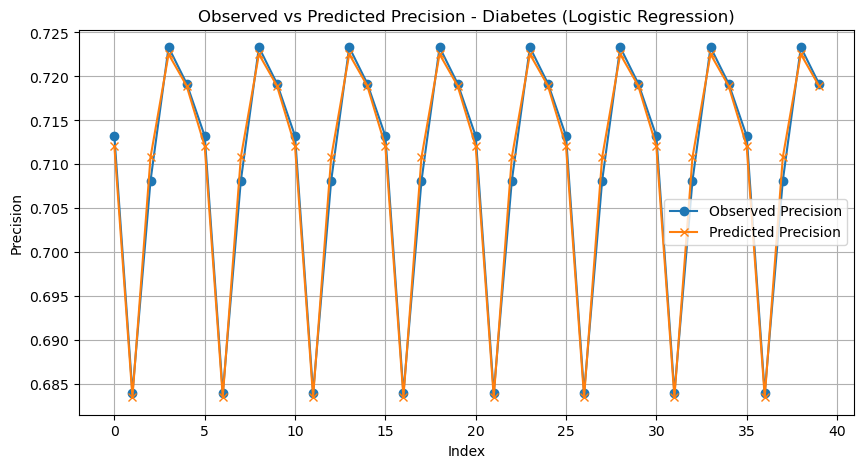

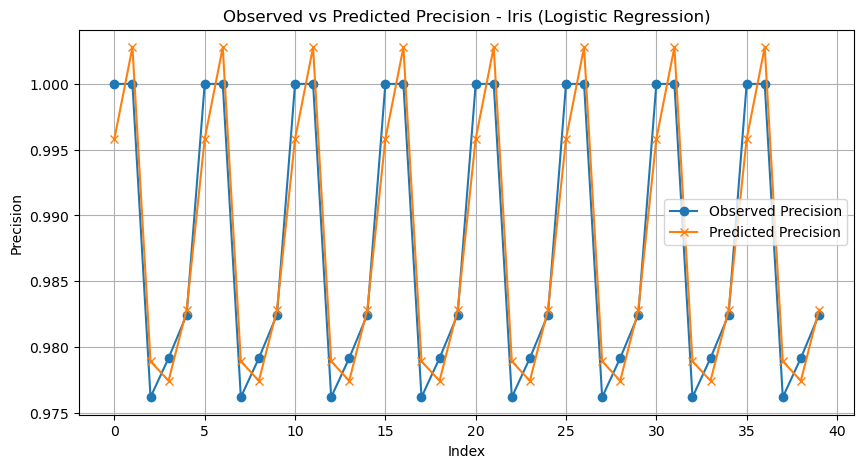

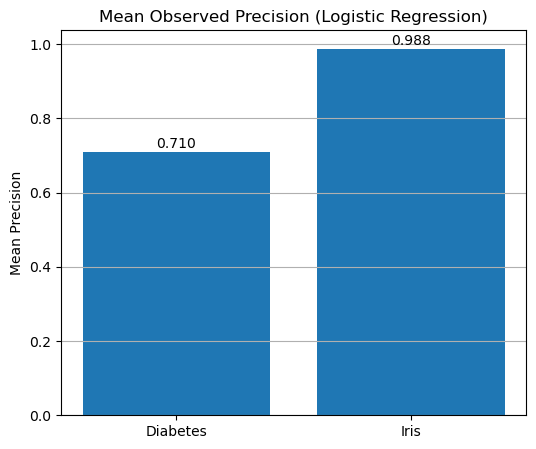

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import precision_score, mean_squared_error
from scipy.stats import entropy

# Function to compute entropies for Logistic Regression with Precision
def compute_entropies_and_precision(max_iter, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lr = LogisticRegression(max_iter=max_iter, solver='lbfgs', random_state=42)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    probs = lr.predict_proba(X_test)

    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)

    # H_D: class distribution entropy from training set
    class_probs = np.bincount(y_train) / len(y_train)
    H_D = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_conf: entropy of prediction confidence (max probability per sample)
    confidences = np.max(probs, axis=1)
    confidence_bins = np.histogram(confidences, bins=10, range=(0, 1))[0]
    confidence_probs = confidence_bins / np.sum(confidence_bins)
    confidence_probs = confidence_probs[confidence_probs > 0]
    H_conf = entropy(confidence_probs, base=2) if len(confidence_probs) > 0 else 0.0

    return H_D, H_pred, H_conf, prec

# Dataset configurations
datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("Iris.csv", "Species")
]

# Process each dataset with Logistic Regression
for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"Logistic Regression - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        # Load dataset
        data = pd.read_csv(csv_file)
        
        # Drop non-numeric and irrelevant columns
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        
        # Drop rows with missing values
        data = data.dropna()
        
        # Encode categorical columns
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        # Run multiple configurations with different max_iter values
        records = []
        for max_iter in [100, 200, 500, 1000, 1500, 2000, 3000, 5000]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_D, H_pred, H_conf, prec = compute_entropies_and_precision(max_iter, test_size=split)
                records.append({
                    "max_iter": max_iter,
                    "split": split,
                    "H_D": H_D,
                    "H_pred": H_pred,
                    "H_conf": H_conf,
                    "Precision": prec
                })
        
        df = pd.DataFrame(records)
        
        # Linear regression: Precision as function of entropies
        X_reg = df[["H_D", "H_pred", "H_conf"]].values
        y_reg = df["Precision"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        # Coefficients
        coeffs = pd.DataFrame({
            "Entropy": ["H_D", "H_pred", "H_conf"],
            "Coefficient (β)": model.coef_
        })
        
        # Compute MSE and RMSE
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: Logistic Regression")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted Precision:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table (with max_iter and split variations):")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        # Summary statistics
        print(f"\nSummary Statistics:")
        print(f"Mean Observed Precision: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted Precision: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# =====================================================================
# Diabetes Observed & Predicted (Logistic Regression)
# =====================================================================

obs_diabetes = [
    0.713225, 0.683977, 0.708132, 0.723325, 0.719190,
    0.713225, 0.683977, 0.708132, 0.723325, 0.719190,
    0.713225, 0.683977, 0.708132, 0.723325, 0.719190,
    0.713225, 0.683977, 0.708132, 0.723325, 0.719190,
    0.713225, 0.683977, 0.708132, 0.723325, 0.719190,
    0.713225, 0.683977, 0.708132, 0.723325, 0.719190,
    0.713225, 0.683977, 0.708132, 0.723325, 0.719190,
    0.713225, 0.683977, 0.708132, 0.723325, 0.719190
]

pred_diabetes = [
    0.712073, 0.683507, 0.710804, 0.722533, 0.718933,
    0.712073, 0.683507, 0.710804, 0.722533, 0.718933,
    0.712073, 0.683507, 0.710804, 0.722533, 0.718933,
    0.712073, 0.683507, 0.710804, 0.722533, 0.718933,
    0.712073, 0.683507, 0.710804, 0.722533, 0.718933,
    0.712073, 0.683507, 0.710804, 0.722533, 0.718933,
    0.712073, 0.683507, 0.710804, 0.722533, 0.718933,
    0.712073, 0.683507, 0.710804, 0.722533, 0.718933
]


# =====================================================================
# Iris Observed & Predicted (Logistic Regression)
# =====================================================================

obs_iris = [
    1.000000, 1.000000, 0.976190, 0.979167, 0.982456,
    1.000000, 1.000000, 0.976190, 0.979167, 0.982456,
    1.000000, 1.000000, 0.976190, 0.979167, 0.982456,
    1.000000, 1.000000, 0.976190, 0.979167, 0.982456,
    1.000000, 1.000000, 0.976190, 0.979167, 0.982456,
    1.000000, 1.000000, 0.976190, 0.979167, 0.982456,
    1.000000, 1.000000, 0.976190, 0.979167, 0.982456,
    1.000000, 1.000000, 0.976190, 0.979167, 0.982456
]

pred_iris = [
    0.995819, 1.002788, 0.978923, 0.977437, 0.982847,
    0.995819, 1.002788, 0.978923, 0.977437, 0.982847,
    0.995819, 1.002788, 0.978923, 0.977437, 0.982847,
    0.995819, 1.002788, 0.978923, 0.977437, 0.982847,
    0.995819, 1.002788, 0.978923, 0.977437, 0.982847,
    0.995819, 1.002788, 0.978923, 0.977437, 0.982847,
    0.995819, 1.002788, 0.978923, 0.977437, 0.982847,
    0.995819, 1.002788, 0.978923, 0.977437, 0.982847
]


# =====================================================================
# Compute Mean Values
# =====================================================================
mean_obs_diabetes = sum(obs_diabetes) / len(obs_diabetes)
mean_obs_iris = sum(obs_iris) / len(obs_iris)

mean_pred_diabetes = sum(pred_diabetes) / len(pred_diabetes)
mean_pred_iris = sum(pred_iris) / len(pred_iris)


# =====================================================================
# 1️⃣ Plot — Observed vs Predicted (Diabetes)
# =====================================================================
plt.figure(figsize=(10,5))
plt.plot(obs_diabetes, marker='o', label="Observed Precision")
plt.plot(pred_diabetes, marker='x', label="Predicted Precision")
plt.title("Observed vs Predicted Precision - Diabetes (Logistic Regression)")
plt.xlabel("Index")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()


# =====================================================================
# 2️⃣ Plot — Observed vs Predicted (Iris)
# =====================================================================
plt.figure(figsize=(10,5))
plt.plot(obs_iris, marker='o', label="Observed Precision")
plt.plot(pred_iris, marker='x', label="Predicted Precision")
plt.title("Observed vs Predicted Precision - Iris (Logistic Regression)")
plt.xlabel("Index")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()


# =====================================================================
# 3️⃣ Bar Plot — Comparison of Mean Observed Precision
# =====================================================================
plt.figure(figsize=(6,5))
plt.bar(["Diabetes", "Iris"], [mean_obs_diabetes, mean_obs_iris])

plt.text(0, mean_obs_diabetes + 0.01, f"{mean_obs_diabetes:.3f}", ha='center')
plt.text(1, mean_obs_iris + 0.01, f"{mean_obs_iris:.3f}", ha='center')

plt.title("Mean Observed Precision (Logistic Regression)")
plt.ylabel("Mean Precision")
plt.grid(axis='y')
plt.show()
